暂时只考虑一维旋转的问题。。。碰撞之后一定会有两个维度上的旋转。。。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, title="", cmap="gray", size=6):
    plt.figure(figsize=(size, size))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def remove_small_components(binary, min_area=200):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    out = np.zeros_like(binary)
    for i in range(1, num):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            out[labels == i] = 255
    return out


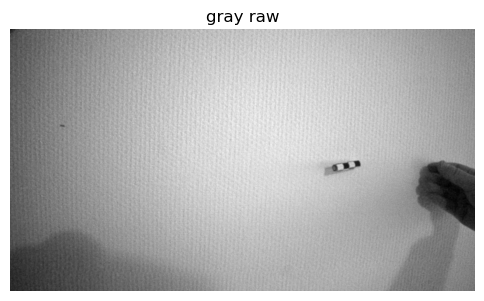

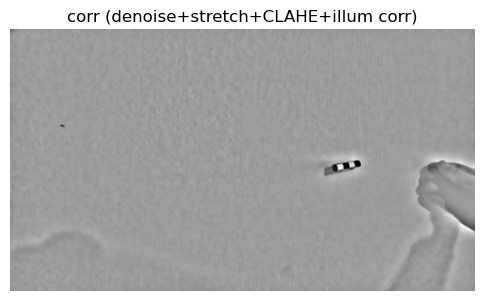

In [2]:
video_path = "/home/xuwentao/IPT-2026/test-videos/cut-4.mp4"

def read_frame(video_path, k):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, k)
    ok, frame = cap.read()
    cap.release()
    return ok, frame

k = 10
ok, frame = read_frame(video_path, k)
assert ok

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# 暗光颗粒：NlMeans 很有效
dn = cv2.fastNlMeansDenoising(gray, None, h=12, templateWindowSize=7, searchWindowSize=21)

# 拉伸
p1, p99 = np.percentile(dn, (1, 99))
stretch = np.clip((dn - p1) * 255.0 / max(p99 - p1, 1e-6), 0, 255).astype(np.uint8)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
eq = clahe.apply(stretch)

# 光照校正（去掉大范围渐变）
bg = cv2.GaussianBlur(eq, (0,0), sigmaX=25, sigmaY=25)
corr = cv2.addWeighted(eq, 1.0, bg, -1.0, 128)

show(gray, "gray raw")
show(corr, "corr (denoise+stretch+CLAHE+illum corr)")


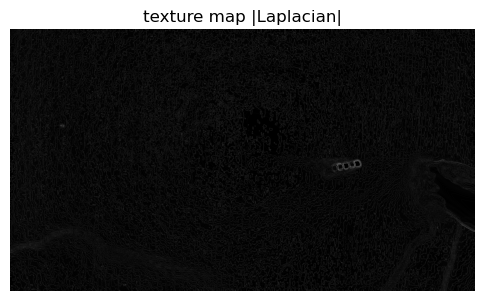

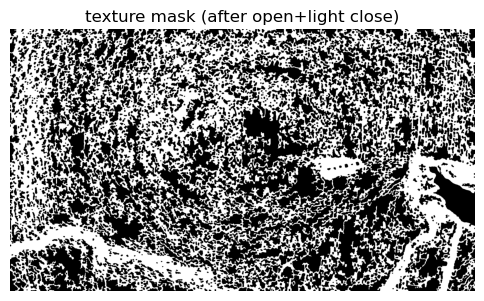

In [3]:
# 纹理强度：Laplacian
lap = cv2.Laplacian(corr, cv2.CV_32F, ksize=3)
tex = np.abs(lap).astype(np.uint8)

# 让纹理“成片”：轻微平滑
tex_blur = cv2.GaussianBlur(tex, (0,0), sigmaX=2, sigmaY=2)

# 阈值：Otsu 自动
_, tex_bw = cv2.threshold(tex_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# --- 阈值后先做 OPEN 去掉散点，再做轻量 CLOSE 连接电池纹理 ---
k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
tex_bw2 = cv2.morphologyEx(tex_bw, cv2.MORPH_OPEN, k_open, iterations=1)

k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # 5 比 7/9/11 更不易把整图黏住
tex_bw2 = cv2.morphologyEx(tex_bw2, cv2.MORPH_CLOSE, k_close, iterations=1)

tex_bw2 = remove_small_components(tex_bw2, min_area=300)

# 用处理后的掩码覆盖原名，保证后续单元使用一致
tex_bw = tex_bw2

show(tex, "texture map |Laplacian|")
show(tex_bw, "texture mask (after open+light close)", cmap="gray")


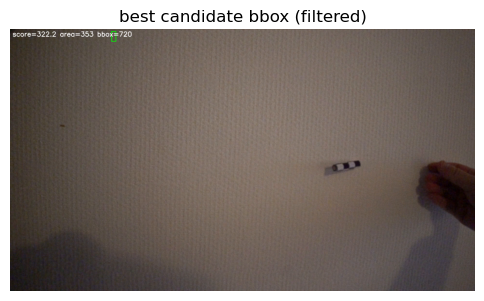

In [4]:
bw = tex_bw2  # 用上面改好的 tex_bw2

H, W = bw.shape[:2]
num, labels, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity=8)

def score_component(i):
    x, y, w, h, area = stats[i]

    # 1) 触边直接踢掉（整幅画面组件一般都会触边）
    margin = 3
    if x <= margin or y <= margin or (x+w) >= (W-margin) or (y+h) >= (H-margin):
        return None

    # 2) 基本面积约束
    if area < 200 or area > 20000:
        return None

    # 3) 细长约束
    aspect = max(w, h) / max(min(w, h), 1)
    if aspect < 2.0:
        return None

    # 4) bbox 占比约束（避免“大而稀”的背景团）
    bbox_area = w * h
    if bbox_area > 0.20 * (W * H):   # bbox 超过画面 20% 就太大了，按需调 0.15~0.30
        return None

    # 5) 填充率：area / bbox_area（背景纹理团通常很稀，fill 很小）
    fill = area / max(bbox_area, 1)
    if fill < 0.12:   # 稀疏就踢掉，按需调 0.08~0.20
        return None

    # 6) 纹理强度（你之前的 tex_blur）
    mask = (labels == i)
    mean_tex = float(tex_blur[mask].mean())

    # 打分：纹理强 + 细长 + 面积适中 + 填充率合理
    score = mean_tex * 5.0 + aspect * 60.0 + fill * 300.0 + area * 0.005
    return score

best_i, best_s = None, -1e18
for i in range(1, num):
    s = score_component(i)
    if s is not None and s > best_s:
        best_s, best_i = s, i

vis = frame.copy()
if best_i is None:
    print("No candidate found: reduce thresholds or shrink ROI.")
else:
    x, y, w, h, area = stats[best_i]
    cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(vis, f"score={best_s:.1f} area={area} bbox={w*h}", (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

show(vis, "best candidate bbox (filtered)")
